In [27]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [28]:
class Value:
  def __init__(self, data, _children=(), _op="", label = ""):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad # previously = 1.0 * out.grad which caused backpropogation bug when same node used twice
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad 
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other):
    return self * other
  
  def sigmoid(self):
    x = self.data
    t = 1 / (1 + math.exp(-x))
    out = Value(t, (self, ), "sigmoid")

    def _backward():
        self.grad += t * (1 - t) * out.grad
    out._backward = _backward
    
    return out

  def relu(self):
    x = self.data
    t = 0 if x < 0 else x
    out = Value(t, (self, ), "relu")

    def _backward():
      self.grad += (t > 0) * out.grad
    out._backward = _backward

    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self,), "tanh")

    def _backward():
      self.grad += (1 - (t ** 2)) * out.grad
    out._backward = _backward
    
    return out 
  
  def exp(self):
    x = self.data
    e = math.exp(x)
    out = Value(e, (self,), "exp")

    def _backward():
      self.grad = e * out.grad
    out._backward = _backward

    return out
  
  def __truediv__(self, other):
    return self * other**-1
  
  def __pow__(self, other):
    out = Value(self.data**other, (self, ), f"**{other}")

    def _backward():
      self.grad += (other * (self.data ** (other - 1))) * out.grad
    out._backward = _backward

    return out

  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)

  def backward(self):
    # topological sort
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1
    for node in reversed(topo):
      node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [29]:
za = Value(2.0)
za += 3
za = 3 + za
za

Value(data=8.0)

In [30]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

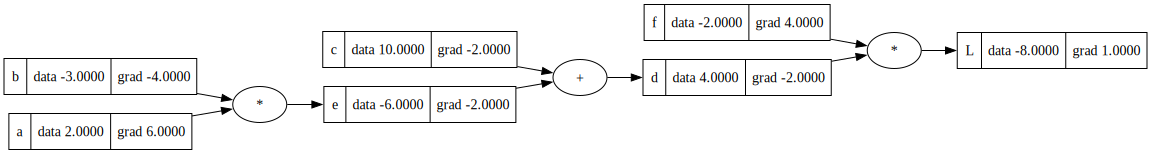

In [31]:
L.grad = 1
f.grad = 4
d.grad = -2
e.grad = -2
c.grad = -2
a.grad = 6
b.grad = -4

draw_dot(L)

In [32]:
def findGrad():
  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h

  return (L2 - L1)/h

findGrad()


0.9999999999621422

In [33]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


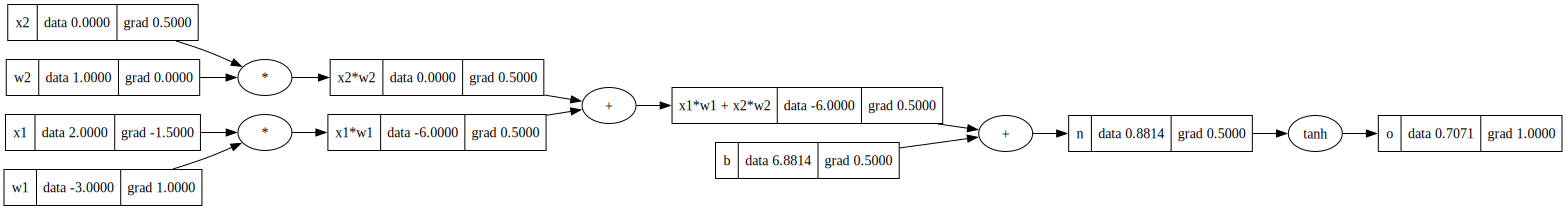

In [34]:
# MANUAL BACKPROPOGATION
o.grad = 1
n.grad = 1 - o.data ** 2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

#d(x2w2)/d(x2) = w2, d(o)/d(x2w2), d(o)/d(x2) = d(o)/d(x2w2) * d(x2w2)/d(x2)
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

draw_dot(o)

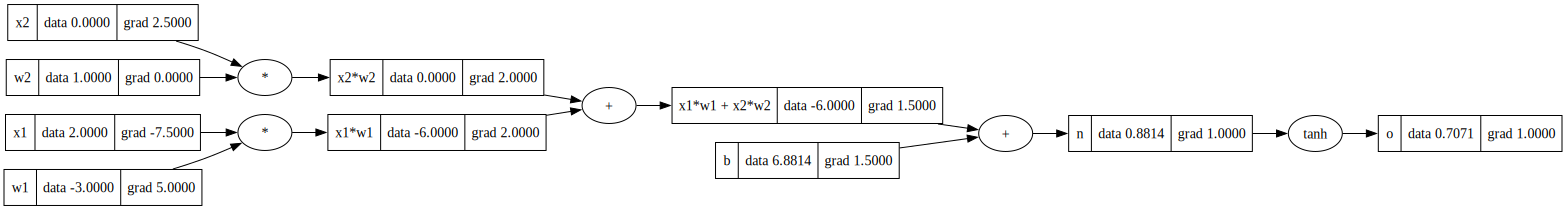

In [35]:
# SEMI MANUAL BACKPROPOGATION

o.grad = 1
o._backward()
n._backward()
b._backward() # does nothing cuz leaf node
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

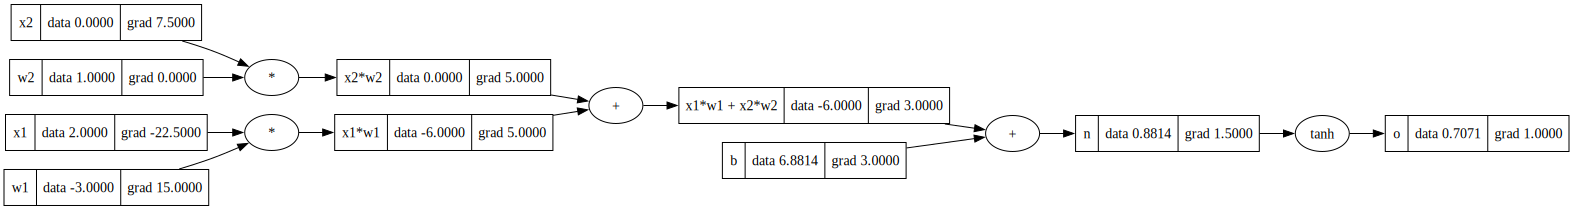

In [36]:
# AUTO BACKPROPOGATION

o.grad = 1

# topological sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

draw_dot(o)

# implement this functionality into the class

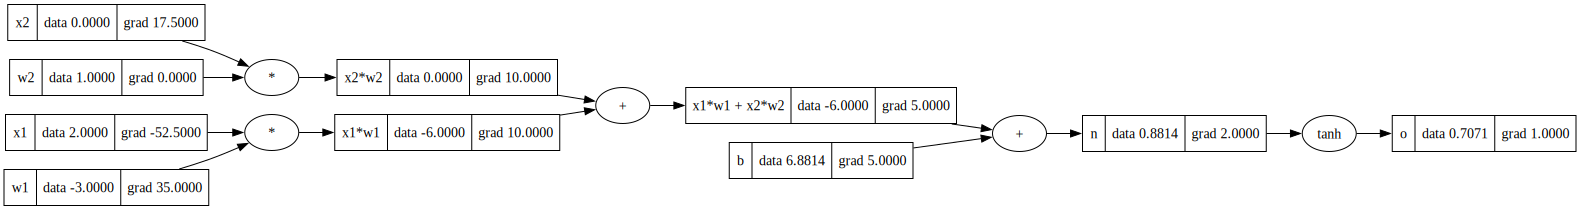

In [37]:
# BACKPROPOGATION USING CLASS BACKWARD FUNCTION

o.backward()
draw_dot(o)

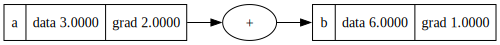

In [38]:
# BACKPROPOGATION BUG WHEN SAME NODE USED TWICE - 1, FIXED BY ACCUMULATING GRADIENTS INSTEAD OF SETTING THEM

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

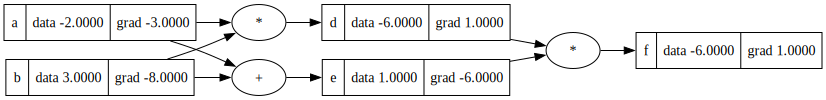

In [39]:
# BACKPROPOGATION BUG WHEN SAME NODE USED TWICE - 2

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [40]:
import torch

In [41]:
t_x1 = torch.tensor([2.0]).double(); t_x1.requires_grad = True
t_w1 = torch.tensor([-3.0]).double(); t_w1.requires_grad = True
t_x2 = torch.tensor([0.0]).double(); t_x2.requires_grad = True
t_w2 = torch.tensor([1.0]).double(); t_w2.requires_grad = True
t_b = torch.tensor([6.8813735870195432]).double(); t_b.requires_grad = True
t_n = t_x1 * t_w1 + t_x2 * t_w2 + t_b
t_o = torch.tanh(t_n)
t_o.backward()

print("output:", t_o.item())
print("x1 grad:", t_x1.grad.item())
print("w1 grad:", t_w1.grad.item())
print("x2 grad:", t_x2.grad.item())
print("w2 grad:", t_w2.grad.item())
print("b grad:", t_b.grad.item())


output: 0.7071066904050358
x1 grad: -1.5000003851533106
w1 grad: 1.0000002567688737
x2 grad: 0.5000001283844369
w2 grad: 0.0
b grad: 0.5000001283844369


In [42]:
import random

In [43]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [44]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.966876345889632)

In [45]:
tiny = [[2.0, 3.0, -1.0],
        [3.0, -1.0, 0.5],
        [0.5, 1.0, 1.0],
        [1.0, 1.0, -1.0]]

target = [1.0, -1.0, -1.0, 1.0]

In [46]:
for k in range(20):
  ypred = [n(x) for x in tiny]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(target, ypred))

  for p in n.parameters():
    p.grad = 0
    
  loss.backward()

  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)


0 7.31915742322093
1 6.047931764834694
2 3.260454823753112
3 1.9622000924899095
4 1.1029599624870183
5 0.6907631360195484
6 0.37448978252488496
7 0.21615892236934112
8 0.1659463289138834
9 0.13576474189088256
10 0.11448591864259712
11 0.09873357220915333
12 0.08663896670098424
13 0.07708202902424283
14 0.06935296668987569
15 0.06298148756670294
16 0.05764433519864811
17 0.053112373167531896
18 0.04921887438813681
19 0.045839760541527746


In [47]:
ypred = [n(x) for x in tiny]
ypred

[Value(data=0.9702003312514365),
 Value(data=-0.9047808441152723),
 Value(data=-0.8755690365383629),
 Value(data=0.867927689501472)]

In [48]:
# testing the new activation functions
# sigmoid
# inputs x1, x2
x1_sigm = Value(3.0, label='x1')
x2_sigm = Value(2.0, label='x2')
# weights w1,w2
w1_sigm = Value(5.0, label='w1')
w2_sigm = Value(-4.0, label='w2')
# bias of the neuron
b_sigm = Value(-2, label='b')
# x1*w1 + x2*w2 + b
x1w1_sigm = x1_sigm*w1_sigm; x1w1_sigm.label = 'x1*w1'
x2w2_sigm = x2_sigm*w2_sigm; x2w2_sigm.label = 'x2*w2'
x1w1x2w2_sigm = x1w1_sigm + x2w2_sigm; x1w1x2w2_sigm.label = 'x1*w1 + x2*w2'
n_sigm = x1w1x2w2_sigm + b_sigm; n_sigm.label = 'n'
o_sigm= n_sigm.sigmoid(); o_sigm.label = 'o'

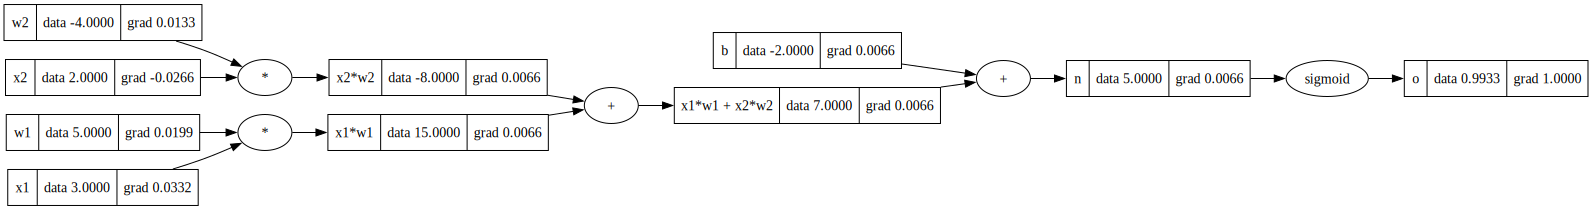

In [49]:
o_sigm.backward()
draw_dot(o_sigm)

In [50]:
# relu
# inputs x1, x2
x1_relu = Value(2.0, label='x1')
x2_relu = Value(0.0, label='x2')
# weights w1,w2
w1_relu = Value(-3.0, label='w1')
w2_relu = Value(1.0, label='w2')
# bias of the neuron
b_relu = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1_relu = x1_relu*w1_relu; x1w1_relu.label = 'x1*w1'
x2w2_relu = x2_relu*w2_relu; x2w2_relu.label = 'x2*w2'
x1w1x2w2_relu = x1w1_relu + x2w2_relu; x1w1x2w2_relu.label = 'x1*w1 + x2*w2'
n_relu = x1w1x2w2_relu + b_relu; n_relu.label = 'n'
o_relu= n_relu.relu(); o_relu.label = 'o'

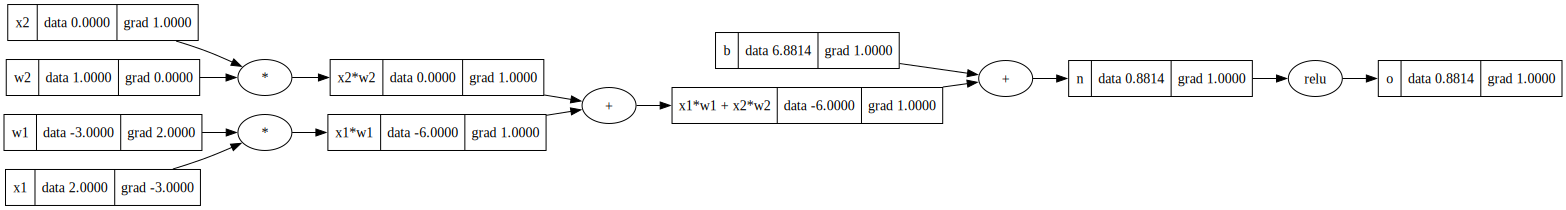

In [51]:
o_relu.backward()
draw_dot(o_relu)